In [1]:
# Installs the Kaggle command-line tool, which is used to interact with the Kaggle platform and download datasets.
# -q is used to speed up installation by reducing the amount of text displayed in the output and only show error if occur.
!pip install -q kaggle
# upload kaggle api .json file to download dataset
from google.colab import files
files.upload()
# make a directory in file system used to store the Kaggle API token, which is required to authenticate with the Kaggle platform and interact with the Kaggle API.
!mkdir -p ~/.kaggle
# copy .json file into new directory
!cp kaggle.json ~/.kaggle/
# Give permission to use .json file for read and write to root user
!chmod 600 /root/.kaggle/kaggle.json
# download dataset from kaggle
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset
# unzip dowloaded dataset
# !unzip /content/tt100k.zip

Saving kaggle.json to kaggle.json
 98% 734M/750M [00:07<00:00, 169MB/s]
100% 750M/750M [00:08<00:00, 90.2MB/s]


In [2]:
!unzip /content/stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

In [7]:
! pip install keras_preprocessing --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 895.3 kB/s eta 0:00:00


In [21]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # To use local CPU instead of local GPU
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as implt
from PIL import Image
import keras,cv2,shutil,keras_preprocessing,requests,math,glob, datetime
import tensorflow as tf
from keras import layers
from keras.models import Sequential, Model
from keras.layers import Lambda, Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation, SpatialDropout2D, GlobalAveragePooling2D
# from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input as inception_preprocessor
from keras.applications.xception import Xception, preprocess_input as xception_preprocessor
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input as inc_resnet_preprocessor
from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocessor
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.datasets import load_files
from io import BytesIO
import seaborn as sns
import xml.etree.ElementTree as ET
from pathlib import Path
%load_ext tensorboard
shutil.rmtree('./logs', ignore_errors=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [10]:
import glob

dog_images = glob.glob('/content/images/Images/*/*')
breeds = glob.glob('/content/annotations/Annotation*')
annotations = glob.glob('/content/annotations/Annotation/*/*')
cropped = "./Cropped/"
img_size = 299 # For Xception input
train_dir = './Cropped' # './Images'
batch_size_training = 256
batch_size_validation = 256
input_shape = (img_size,img_size,3)

In [34]:

# ######## Plot Metrics Function ########
# def plot_metric(history, metric):
#     train_metrics = history.history[metric]
#     val_metrics = history.history['val_'+metric]
#     epochs = range(1, len(train_metrics) + 1)
#     plt.plot(epochs, train_metrics)
#     plt.plot(epochs, val_metrics)
#     plt.title('Training and validation '+ metric)
#     plt.xlabel("Epochs")
#     plt.ylabel(metric)
#     plt.legend(["train_"+metric, 'val_'+metric])
#     plt.show()

######## Read X and Y coordinate ranges from an annotation ########
def get_bounding_boxes(annot):
    xml = annot
    tree = ET.parse(xml)
    root = tree.getroot()
    objects = root.findall('object')
    bbox = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        bbox.append((xmin,ymin,xmax,ymax))
    return bbox

######## Get image path from annotation path ########
def get_image(annot):
    img_path = '/content/images/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

# ######## Fill image with black to make a square (not used) ########
# def make_square(im, min_size=100, fill_color=(0, 0, 0, 0)):
#     x, y = im.size
#     size = max(min_size, x, y)
#     new_im = Image.new('RGB', (size, size), fill_color)
#     new_im.paste(im, (int((size - x) / 2), int((size - y) / 2)))
#     return new_im

# ######## Preprocess and get predictions from data with a pretrained model ########
# def get_features(model_name, model_preprocessor, input_size, data):
#     input_layer = keras.layers.Input(input_size)
#     preprocessor = Lambda(model_preprocessor)(input_layer)
#     base_model = model_name(weights='imagenet', include_top=False, input_shape=input_size)(preprocessor)
#     feature_extractor = Model(inputs = input_layer, outputs = GlobalAveragePooling2D()(base_model))
#     feature_maps = feature_extractor.predict(data, verbose=1)
#     print('Feature maps shape: ', feature_maps.shape)
#     return feature_maps

# ######## Concatenate all predictions on data for all pretrained models ########
# def extract_all_features(data):
#     inception_features = get_features(InceptionV3, inception_preprocessor, input_shape, data)
#     xception_features = get_features(Xception, xception_preprocessor, input_shape, data)
#     nasnet_features = get_features(NASNetLarge, nasnet_preprocessor, input_shape, data)
#     inc_resnet_features = get_features(InceptionResNetV2, inc_resnet_preprocessor, input_shape, data)
#     extracted_features = np.concatenate([inception_features, xception_features, nasnet_features, inc_resnet_features],axis=-1)
#     return extracted_features

print(len(dog_images), len(breeds), len(annotations))

20580 1 20580


<ipython-input-35-8cad99632440>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize((100,100), Image.ANTIALIAS)


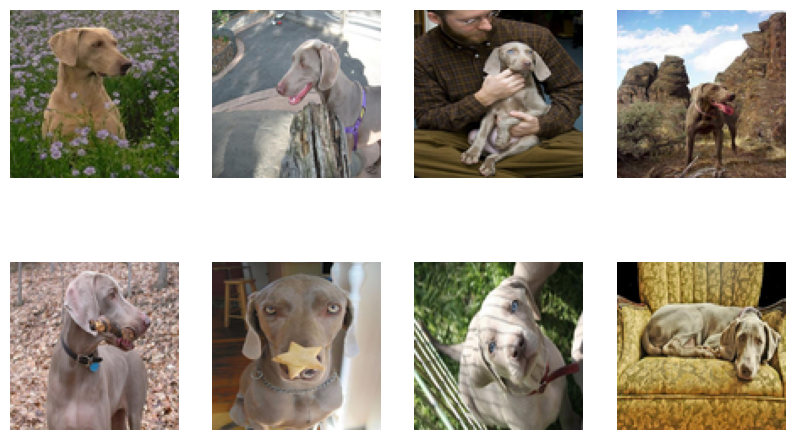

In [35]:
plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    im = Image.open(dog)
    im = im.resize((100,100), Image.ANTIALIAS)
    plt.imshow(im)

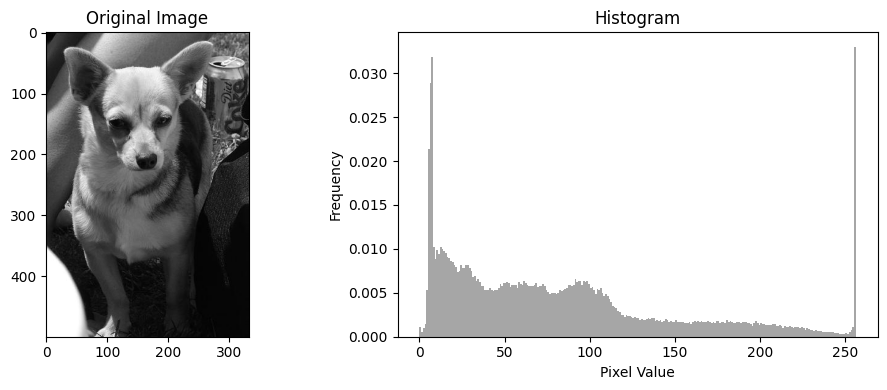

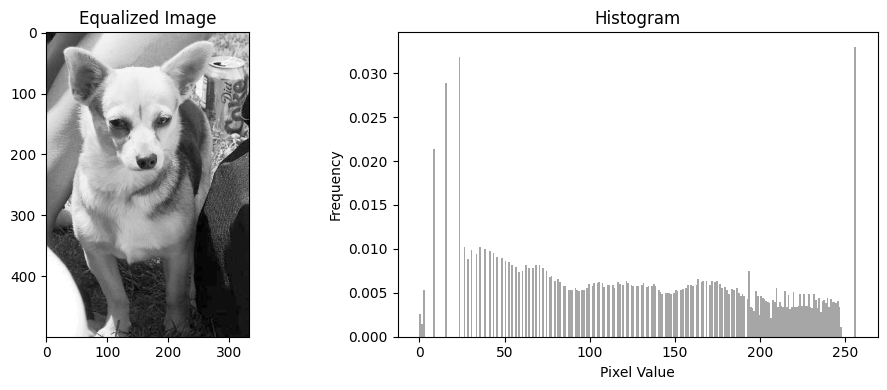

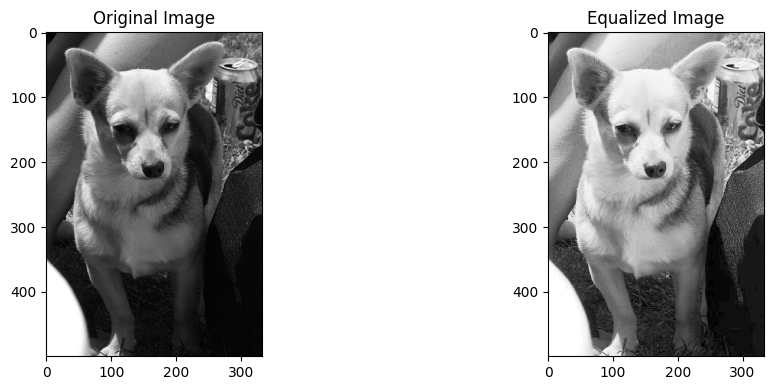

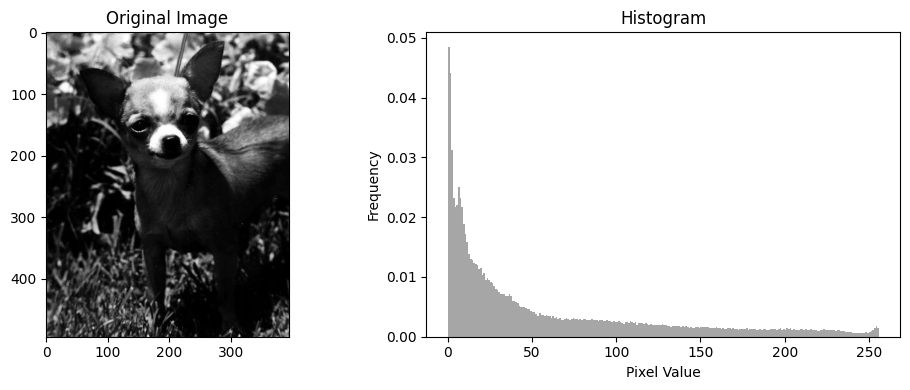

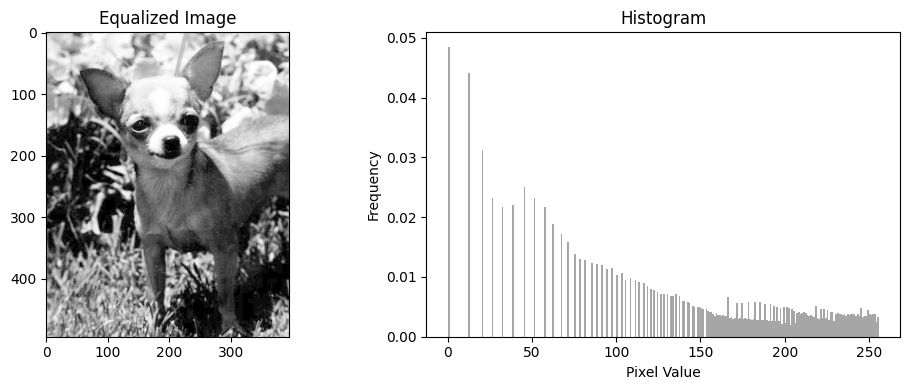

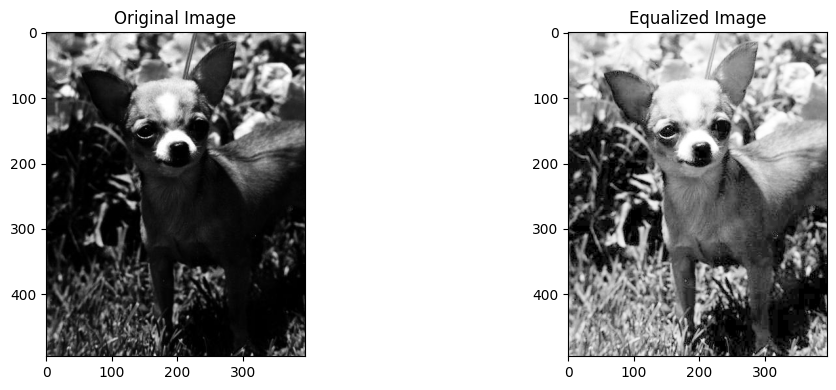

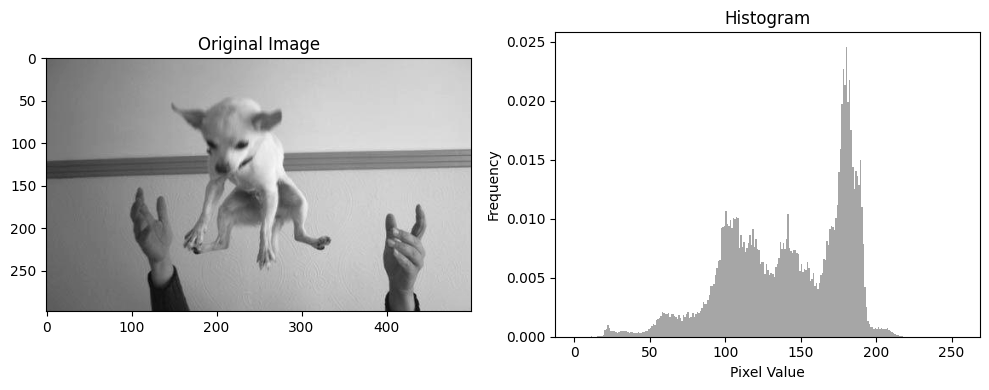

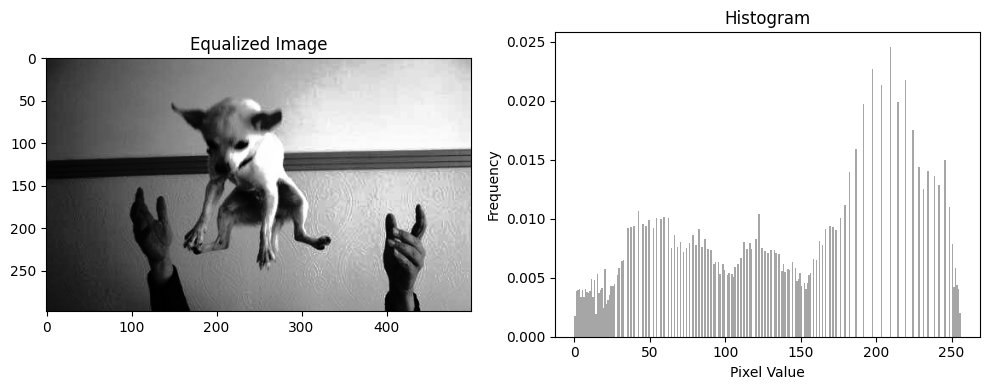

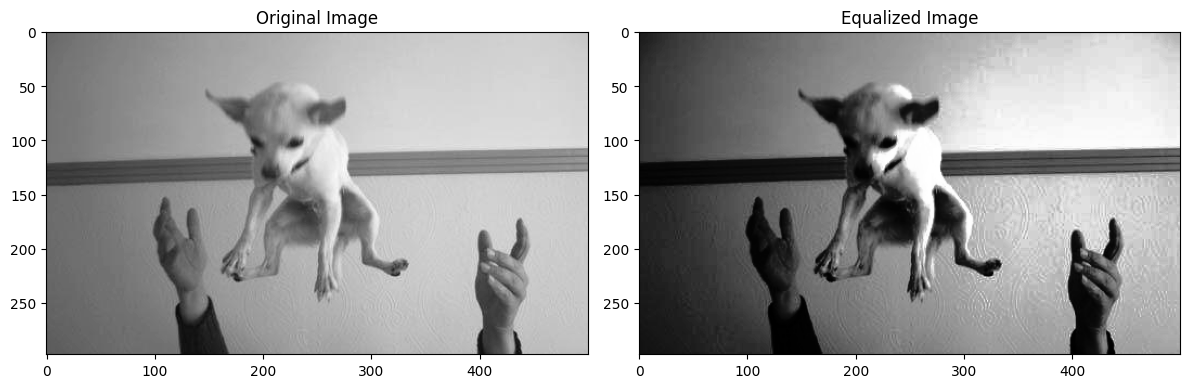

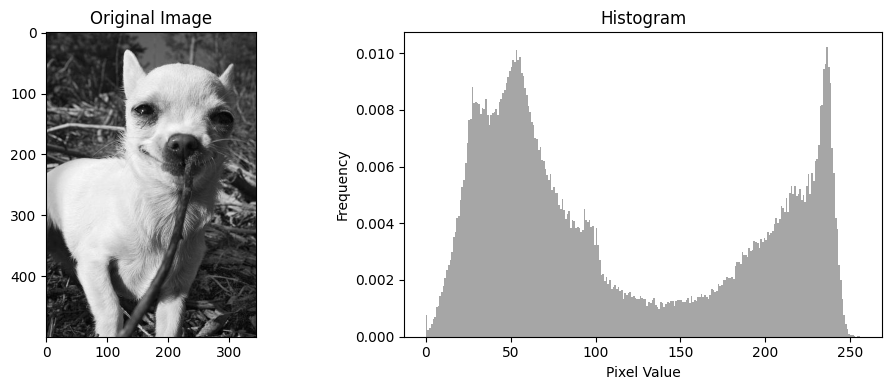

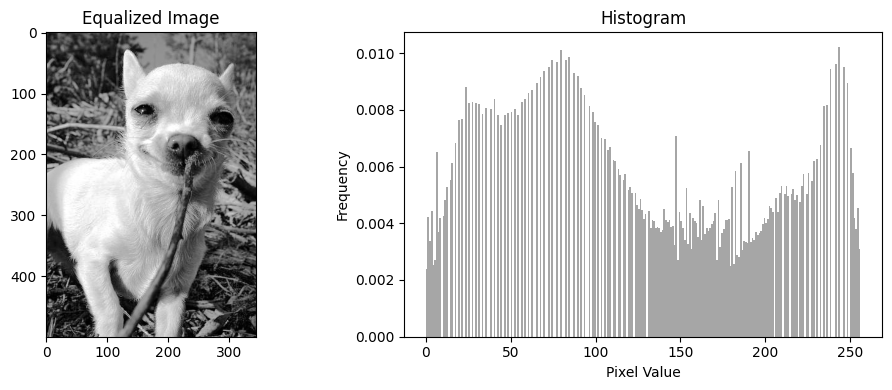

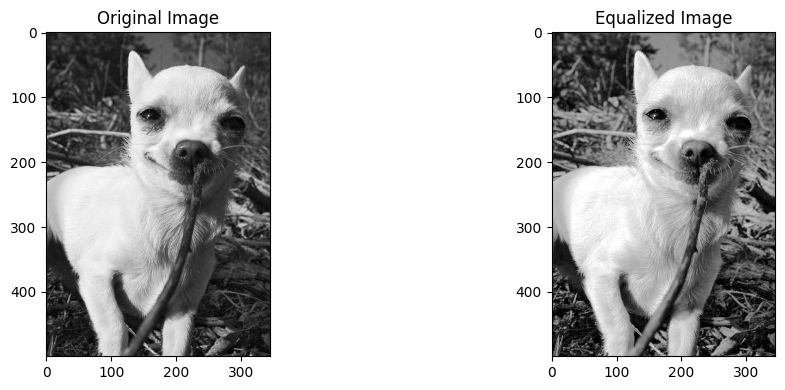

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to perform histogram equalization on a grayscale image
def histogram_equalization(image):
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(image)
    return equalized_image

# Function to plot an image and its histogram
def plot_image_and_histogram(image, title):
    plt.figure(figsize=(10, 4))

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(title)

    # Plot the histogram
    plt.subplot(1, 2, 2)
    plt.hist(image.ravel(), bins=256, range=(0, 256), density=True, color='gray', alpha=0.7)
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.title('Histogram')

    plt.tight_layout()
    plt.show()

# List of image paths (replace with your image paths)
image_paths = [
    '/content/images/Images/n02085620-Chihuahua/n02085620_10074.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_10131.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_10621.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_1073.jpg',
    # Add paths for the other classes and images
]

# Process and plot each image
for image_path in image_paths:
    # Load the image
    original_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Perform histogram equalization
    equalized_image = histogram_equalization(original_image)

    # Plot the original and equalized images along with histograms
    plot_image_and_histogram(original_image, 'Original Image')
    plot_image_and_histogram(equalized_image, 'Equalized Image')

    # Plot the original and equalized images side by side
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Equalized Image')

    plt.tight_layout()
    plt.show()


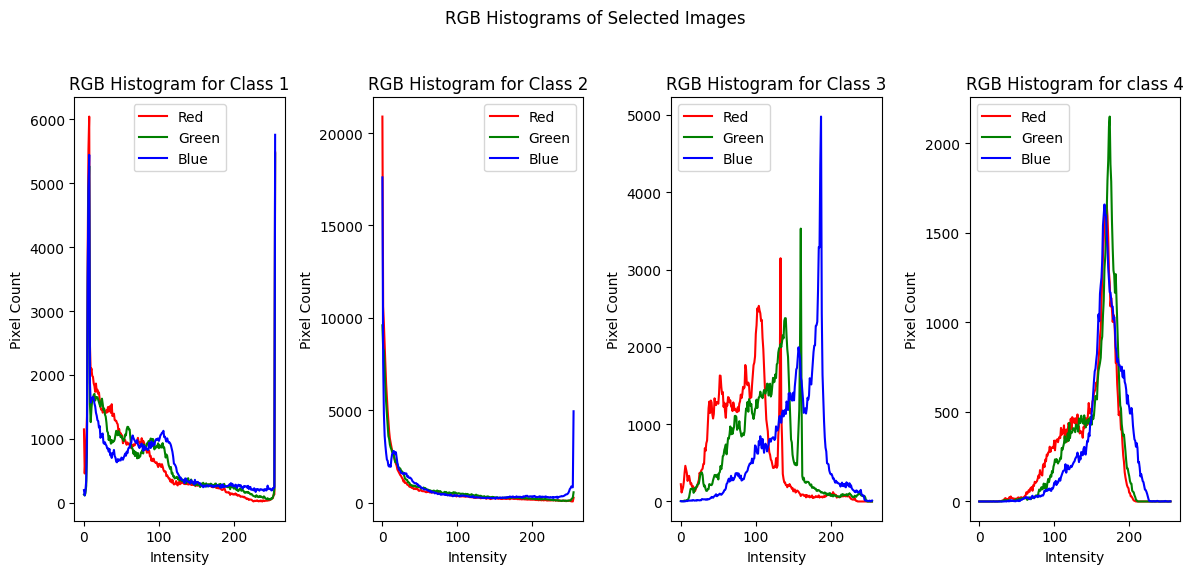

In [38]:
import cv2
import matplotlib.pyplot as plt

# Define the paths to your selected images and their corresponding class names
image_paths = [
    '/content/images/Images/n02085620-Chihuahua/n02085620_10074.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_10131.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_10976.jpg',
    '/content/images/Images/n02085620-Chihuahua/n02085620_11337.jpg',
]

class_names = ['Class 1', 'Class 2', 'Class 3','class 4']  # Replace with your class names

# Function to plot the RGB histogram of an image
def plot_rgb_histogram(image, class_name):
    # Split the image into its RGB channels
    b, g, r = cv2.split(image)

    # Calculate histograms for each channel
    hist_r = cv2.calcHist([r], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([g], [0], None, [256], [0, 256])
    hist_b = cv2.calcHist([b], [0], None, [256], [0, 256])

    # Plot the RGB histograms in a single figure
    plt.plot(hist_r, color='red', label='Red')
    plt.plot(hist_g, color='green', label='Green')
    plt.plot(hist_b, color='blue', label='Blue')
    plt.title(f'RGB Histogram for {class_name}')
    plt.xlabel('Intensity')
    plt.ylabel('Pixel Count')
    plt.legend()

# Create a subplot for each class
plt.figure(figsize=(12, 6))

for i, image_path in enumerate(image_paths):
    class_name = class_names[i]

    # Load the image
    image = cv2.imread(image_path)

    # Convert from BGR to RGB (OpenCV loads images in BGR format)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Create a subplot for the current class
    plt.subplot(1, len(image_paths), i + 1)

    # Plot the RGB histogram for the current image
    plot_rgb_histogram(image, class_name)

# Add overall labels
plt.suptitle('RGB Histograms of Selected Images')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the combined figure with all RGB histograms
plt.show()


In [39]:
import cv2
import numpy as np

# Load the images (replace these with your actual image paths)
image1_class1 = cv2.imread('/content/CroppedImages/n02087046_1004.jpg')
image2_class1 = cv2.imread('/content/CroppedImages/n02087046_133.jpg')
image1_class2 = cv2.imread('/content/CroppedImages/n02087046_1577.jpg')

# Convert the images to grayscale
gray_image1_class1 = cv2.cvtColor(image1_class1, cv2.COLOR_BGR2GRAY)
gray_image2_class1 = cv2.cvtColor(image2_class1, cv2.COLOR_BGR2GRAY)
gray_image1_class2 = cv2.cvtColor(image1_class2, cv2.COLOR_BGR2GRAY)

# Calculate histograms
hist_image1_class1 = cv2.calcHist([gray_image1_class1], [0], None, [256], [0, 256])
hist_image2_class1 = cv2.calcHist([gray_image2_class1], [0], None, [256], [0, 256])
hist_image_class2 = cv2.calcHist([gray_image1_class2], [0], None, [256], [0, 256])

# Normalize histograms
hist_image1_class1 /= hist_image1_class1.sum()
hist_image2_class1 /= hist_image2_class1.sum()
hist_image_class2 /= hist_image_class2.sum()

# Define functions for distance metrics

# Euclidean Distance
def euclidean_distance(hist1, hist2):
    return np.sqrt(np.sum((hist1 - hist2) ** 2))

# Manhattan Distance
def manhattan_distance(hist1, hist2):
    return np.sum(np.abs(hist1 - hist2))

# Bhattacharyya Distance
def bhattacharyya_distance(hist1, hist2):
    return -np.log(np.sum(np.sqrt(hist1 * hist2)))

# Histogram Intersection
def histogram_intersection(hist1, hist2):
    return np.sum(np.minimum(hist1, hist2))

# Calculate distances
euclidean_same_class = euclidean_distance(hist_image1_class1, hist_image2_class1)
euclidean_diff_class = euclidean_distance(hist_image1_class1, hist_image_class2)

manhattan_same_class = manhattan_distance(hist_image1_class1, hist_image2_class1)
manhattan_diff_class = manhattan_distance(hist_image1_class1, hist_image_class2)

bhattacharyya_same_class = bhattacharyya_distance(hist_image1_class1, hist_image2_class1)
bhattacharyya_diff_class = bhattacharyya_distance(hist_image1_class1, hist_image_class2)

intersection_same_class = histogram_intersection(hist_image1_class1, hist_image2_class1)
intersection_diff_class = histogram_intersection(hist_image1_class1, hist_image_class2)

# Print the distances
print(f'Euclidean Distance (Same Class): {euclidean_same_class}')
print(f'Euclidean Distance (Different Classes): {euclidean_diff_class}')

print(f'Manhattan Distance (Same Class): {manhattan_same_class}')
print(f'Manhattan Distance (Different Classes): {manhattan_diff_class}')

print(f'Bhattacharyya Distance (Same Class): {bhattacharyya_same_class}')
print(f'Bhattacharyya Distance (Different Classes): {bhattacharyya_diff_class}')

print(f'Intersection (Same Class): {intersection_same_class}')
print(f'Intersection (Different Classes): {intersection_diff_class}')


Euclidean Distance (Same Class): 0.22975687682628632
Euclidean Distance (Different Classes): 0.35786473751068115
Manhattan Distance (Same Class): 1.1119999885559082
Manhattan Distance (Different Classes): 0.8589999675750732
Bhattacharyya Distance (Same Class): 0.3300553858280182
Bhattacharyya Distance (Different Classes): 0.1671312153339386
Intersection (Same Class): 0.4439999461174011
Intersection (Different Classes): 0.5705000162124634


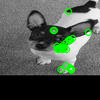

In [42]:
import cv2 as cv
from google.colab.patches import cv2_imshow

# Load an image
img = cv.imread('/content/CroppedImages/n02087046_1004.jpg', cv.IMREAD_GRAYSCALE)

# Define the edge_threshold
edge_threshold = 10  # You can adjust this value as needed

# Initialize the ORB detector with your preferred parameters
orb = cv.ORB_create(
    edgeThreshold=edge_threshold,
    patchSize=30,
    nlevels=8,
    fastThreshold=20,
    scaleFactor=1.2,
    WTA_K=2,
    scoreType=cv.ORB_HARRIS_SCORE,
    firstLevel=0,
    nfeatures=30
)

# Find the keypoints with ORB
kp = orb.detect(img, None)

# Draw only keypoints' locations, not size and orientation
img_with_keypoints = cv.drawKeypoints(img, kp, None, color=(0, 255, 0))

# Display the image with keypoints
cv2_imshow(img_with_keypoints)


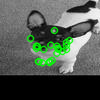

Number of keypoints extracted: 22
Edge threshold value: 30
Patch size: 30


In [43]:
import cv2 as cv
from google.colab.patches import cv2_imshow

# Load an image
img = cv.imread('/content/CroppedImages/n02087046_1004.jpg', cv.IMREAD_GRAYSCALE)

# Define the edge_threshold (same as patchSize)
edge_threshold = 30  # You can adjust this value as needed

# Initialize the ORB detector with the desired number of keypoints (between 25 and 75)
nfeatures_min = 25
nfeatures_max = 75
nfeatures = max(nfeatures_min, min(nfeatures_max, 50))  # Ensure it's within the desired range

orb = cv.ORB_create(
    edgeThreshold=edge_threshold,
    patchSize=edge_threshold,  # Matching patchSize to edgeThreshold
    nlevels=8,
    fastThreshold=20,
    scaleFactor=1.2,
    WTA_K=2,
    scoreType=cv.ORB_HARRIS_SCORE,
    firstLevel=0,
    nfeatures=nfeatures  # Set to the computed number of keypoints
)

# Find the keypoints with ORB
kp = orb.detect(img, None)

# Draw only keypoints' locations, not size and orientation
img_with_keypoints = cv.drawKeypoints(img, kp, None, color=(0, 255, 0))

# Display the image with keypoints
cv2_imshow(img_with_keypoints)

# Print the number of keypoints extracted, edge threshold, and patchSize
print("Number of keypoints extracted:", len(kp))
print("Edge threshold value:", edge_threshold)
print("Patch size:", edge_threshold)


In [44]:
import cv2
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Assuming you have collected and organized grayscale pixel intensity histograms into 'histograms'
# Each row in 'histograms' represents one image's histogram
# Also, you have class labels in 'class_labels' where each label corresponds to a class for each histogram

# Normalize the dataset (mean=0, std=1)
scaler = StandardScaler()
normalized_histograms = scaler.fit_transform(histograms)

# Perform PCA dimensionality reduction to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(normalized_histograms)

# Create a scatter plot of the PCA results with different colors for each class
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[class_labels == 0, 0], pca_result[class_labels == 0, 1], label="Class 0", c="red")
plt.scatter(pca_result[class_labels == 1, 0], pca_result[class_labels == 1, 1], label="Class 1", c="blue")
plt.title("PCA Dimensionality Reduction")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# The variable 'pca_result' now contains the reduced-dimensional representation of your data.


NameError: ignored